# Unsupervised Learning

## TACC Intro to Machine Learning July 2024

### Overview

This Jupyter Notebook accompanies the lecture slides for TACC Intro to Machine Learning July 2024 course. Figures in those slides were created using code in this notebook unless otherwise specified.

### Instructions

Run the code blocks in the order presented and consider the outputs.

Some sections contain questions and additional exercises you can complete.

### Objective

After working through this notebook, you should gain experience in the following areas:

- Simulating data using functions provided in `sklearn` and `numpy`.
- Implementing unsupervised learning methods on simulated and example datasets:
    - Principal Components Analysis
    - K-Means Clustering
    - Agglomerative Hierarchical Clustering
    - Gaussian Mixture Models
    - DBSCAN Clustering
- Summarizing and interpreting the outputs of these unsupervised learning methods.

    
# Hands-on break \#1

## [Setup Materials](#setup)
- ### [Package Installation](#pkgs)
- ### [Plotting Utilities](#plotting)

## [Data Representation](#rep)
- ### [Principal Components Analysis (PCA) Example 1: Tumor Classification](#pca1)
    - ### [Exercise 1](#ex1)
- ### [PCA Example 2: Flower Identification](#pca2)
- ### [PCA Example 3: Noise Reduction](#pca3)
- ### [Multidimensional Scaling](#mds)
- ### [Locally Linear Embedding](#lle)
- ### [T-SNE](#tsne)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
from matplotlib.colors import ListedColormap, colorConverter, LinearSegmentedColormap
mpl.rcParams.update({'font.size': 16})
import sklearn
#from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

We can print the versions of each package to confirm we have the expected versions:

In [2]:
np.__version__

'1.24.3'

In [3]:
sklearn.__version__

'1.1.1'

In [4]:
mpl.__version__

'3.5.2'

In [5]:
pd.__version__

'1.4.4'

In [6]:
scipy.__version__

'1.8.1'

## Plotting Utilities <a name="plotting"></a>

We will use this custom function, which is built on Matplotlib, to generate plots for the exercises in this notebook.

In [7]:
def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    current_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
        mask = y == yy
        # if c is none, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # use light edge for dark markers
        if np.mean(colorConverter.to_rgb(color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, c=color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lines

# Data Representation <a name="rep"></a>

## Principal Components Analysis (PCA) Example 1: Tumor Classification <a name="pca1"></a>

This example uses the breast cancer example data distributed with `scikit-learn`.

### Data Exploration <a name="explore"></a>

Convert data to pandas data frame for pre-analysis exploration:

In [8]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
cancer_df = pd.DataFrame(cancer.data)
cancer_df.columns = cancer.feature_names
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


There are 569 observations (rows) of 30 variables (columns) in this data set:

In [9]:
cancer_df.shape

(569, 30)

We can plot the pairwise correlations between the variables. If we plot all the variables at once it will create a figure that is very hard to read, so for this example we only look at four variables. (Try running the `pd.plotting.scatter_matrix()` function on the entire dataset to see happens).

/var/folders/xg/y_zv5b2d0ksc2158lqgy3c0w0000gp/T/ipykernel_83542/3728780785.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pairplt = pd.plotting.scatter_matrix(


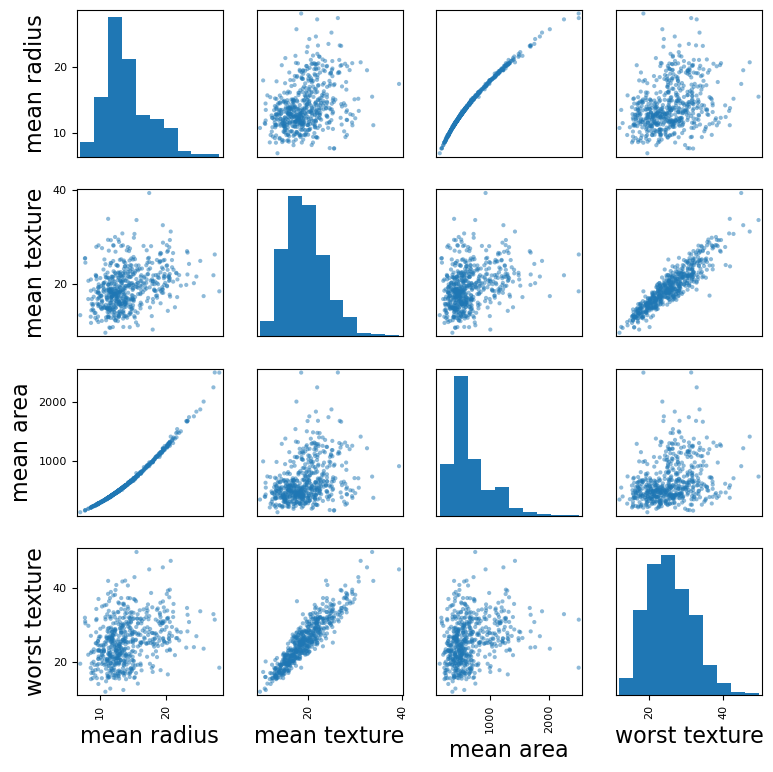

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
pairplt = pd.plotting.scatter_matrix(
    cancer_df[['mean radius', 'mean texture', 'mean area', 'worst texture']],
    ax=ax
)
plt.tight_layout()

In [11]:
# Plot all the data.
# Not run: this figure takes a while to render.
# fig, ax = plt.subplots(1, 1, figsize=(8,8))
# pairplt = pd.plotting.scatter_matrix(cancer_df, ax=ax)
# plt.tight_layout()

### Perform PCA <a name="realpca"></a>

We will work with the data set in the form provided by `scikit-learn` (not the pandas data frame we made above).

We must re-scale the data so that each of the 30 variables are measured on the same scale. This allows us to make fair comparisons between variances.

In [12]:
scaler = StandardScaler()
scaler.fit(cancer.data) # standardize each feature to same scale
X_scaled = scaler.transform(cancer.data)

Now we can conduct the PCA. We will ask the algorithm to keep only the first two principal components.

Original shape: (569, 30)
Reduced shape: (569, 2)
PCA component shape: (2, 30)
PCA components:
[[ 0.21890244  0.10372458  0.22753729  0.22099499  0.14258969  0.23928535
   0.25840048  0.26085376  0.13816696  0.06436335  0.20597878  0.01742803
   0.21132592  0.20286964  0.01453145  0.17039345  0.15358979  0.1834174
   0.04249842  0.10256832  0.22799663  0.10446933  0.23663968  0.22487053
   0.12795256  0.21009588  0.22876753  0.25088597  0.12290456  0.13178394]
 [-0.23385713 -0.05970609 -0.21518136 -0.23107671  0.18611302  0.15189161
   0.06016536 -0.0347675   0.19034877  0.36657547 -0.10555215  0.08997968
  -0.08945723 -0.15229263  0.20443045  0.2327159   0.19720728  0.13032156
   0.183848    0.28009203 -0.21986638 -0.0454673  -0.19987843 -0.21935186
   0.17230435  0.14359317  0.09796411 -0.00825724  0.14188335  0.27533947]]


Text(0, 0.5, 'Second principal component')

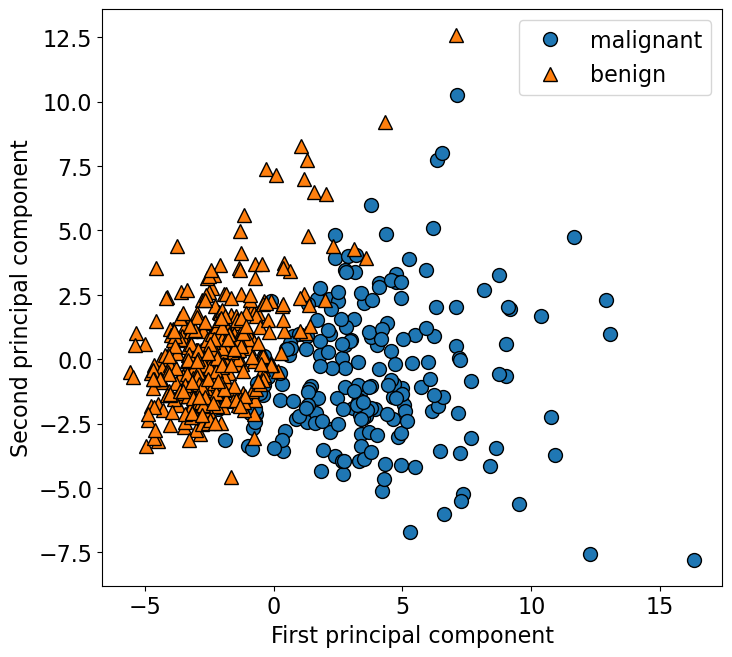

In [13]:
# keep the first two principal components of the data
pca = PCA(n_components=2)
# fit PCA model to beast cancer data
pca.fit(X_scaled)
# transform data onto the first two principal components
X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))
print("PCA component shape: {}".format(pca.components_.shape))
print("PCA components:\n{}".format(pca.components_))

plt.figure(figsize=(8, 8))
discrete_scatter(x1=X_pca[:, 0], x2=X_pca[:, 1], y=cancer.target)
plt.legend(cancer.target_names, loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

We can also inspect what the plot of the first two principal components looks like with and without the indication of the tumor type.

Text(0, 0.5, 'Second principal component')

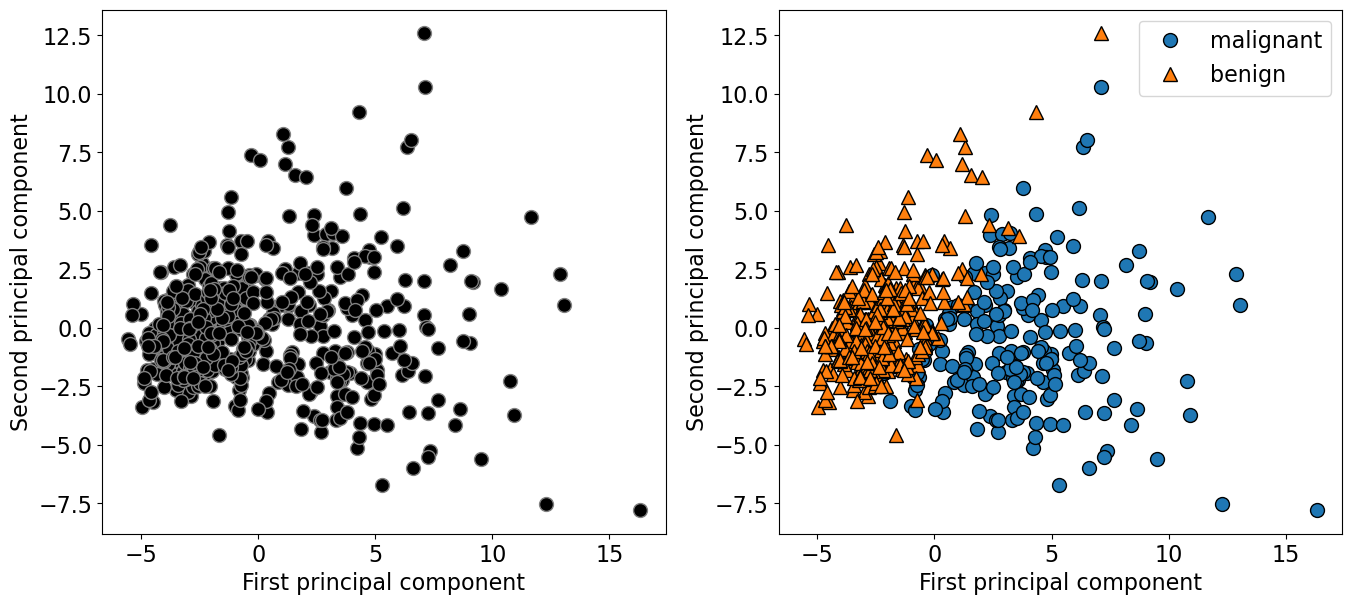

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
discrete_scatter(x1=X_pca[:, 0], x2=X_pca[:, 1], y=cancer.target, markers='o', c='k', ax=ax[0])
ax[0].set_aspect("equal")
ax[0].set_xlabel("First principal component")
ax[0].set_ylabel("Second principal component")

discrete_scatter(x1=X_pca[:, 0], x2=X_pca[:, 1], y=cancer.target, ax=ax[1])
ax[1].legend(cancer.target_names, loc="best")
ax[1].set_aspect("equal")
ax[1].set_xlabel("First principal component")
ax[1].set_ylabel("Second principal component")

We can consider how the cumulative percent variance changes as we add principal components. The red point highlights the cumulative precent variance explained by the first two principal components.

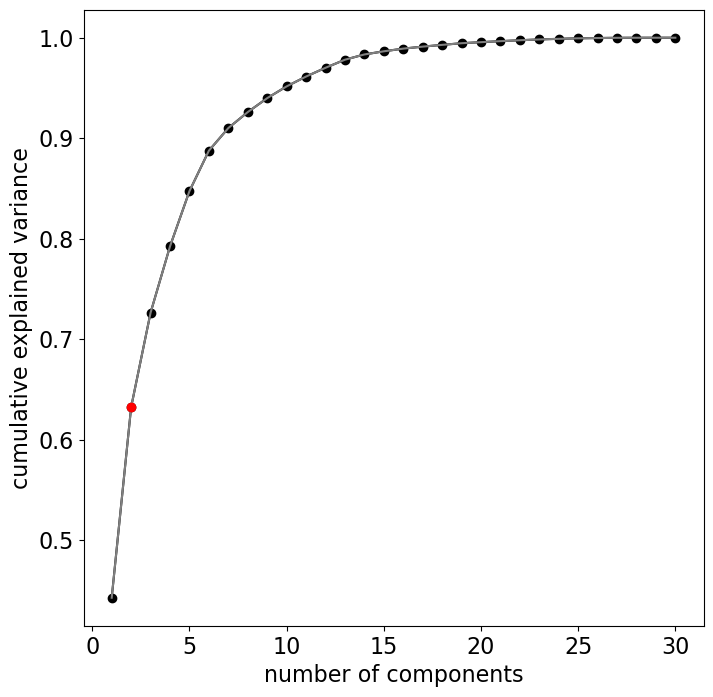

In [15]:
# explained variance of PCA 
from sklearn.decomposition import PCA
cancer = load_breast_cancer()
scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)
pca = PCA().fit(X_scaled)
expl_var = np.cumsum(pca.explained_variance_ratio_)
# fit PCA model to breast cancer data
plt.figure(figsize=(8,8))
plt.plot(range(1, len(expl_var)+1),expl_var, marker='o', color='k')
plt.plot(range(1, len(expl_var)+1),expl_var, color='gray')
plt.plot(2, expl_var[1], marker='o', color='r')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### Hands On Activity \#1 <a name="ex1"></a>

Select a different pair of principal components and plot the tumor data in that space, with points colored by the tumor classification. Do principal components that explain a lower fraction of dataset variance still separate benign and malignant tumors?

*Hint* Modify the number of principal components retained, and take different slices of the data to plot:

    # change the n_components argument to keep more axes of variation
    pca = PCA(n_components=x)  
    pca.fit(X_scaled)
    # fit PCA model to beast cancer data
    # transform data onto the first two principal components
    X_pca = pca.transform(X_scaled)
    print("Original shape: {}".format(str(X_scaled.shape)))
    print("Reduced shape: {}".format(str(X_pca.shape)))
    print("PCA component shape: {}".format(pca.components_.shape))
    print("PCA components:\n{}".format(pca.components_))

    plt.figure(figsize=(8, 8))
    # take different slices of the data by replacing index 0 and 1 with different values
    discrete_scatter(x1=X_pca[:, 0], x2=X_pca[:, 1], y=cancer.target) 
    plt.legend(cancer.target_names, loc="best")
    plt.gca().set_aspect("equal")
    plt.xlabel("First principal component")
    plt.ylabel("Second principal component")

## PCA Example 2: Flower Identification <a name="pca2"></a>

Here we use the setosa data set, which describes flower morphology.

In [16]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

iris = load_iris()
iris_df = pd.DataFrame(iris.data)
iris_df.columns = iris.feature_names
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [17]:
iris_df.shape

(150, 4)

/var/folders/xg/y_zv5b2d0ksc2158lqgy3c0w0000gp/T/ipykernel_83542/3625750498.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pairplt = pd.plotting.scatter_matrix(


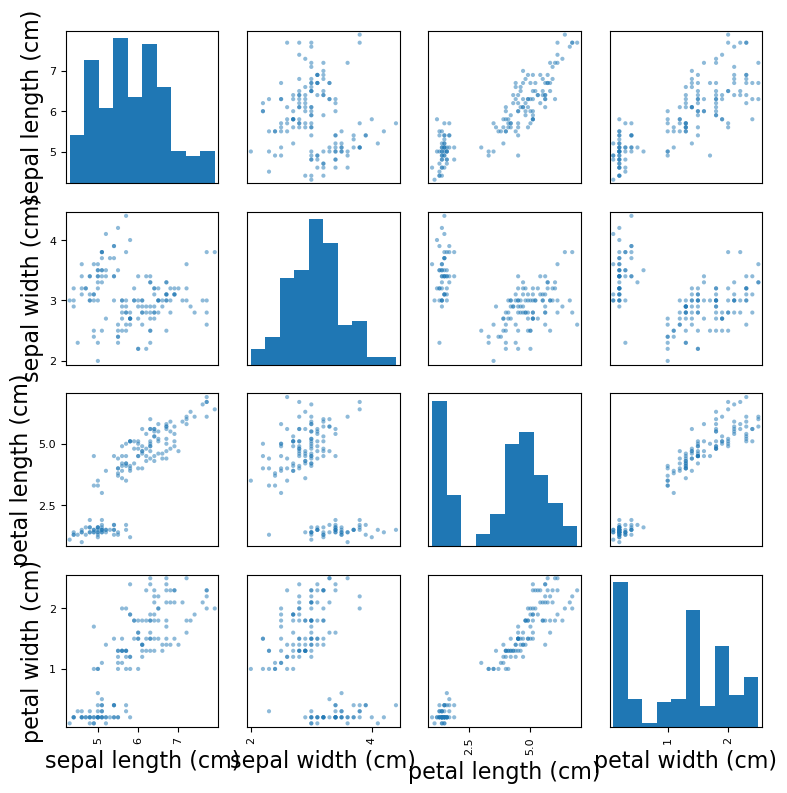

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
pairplt = pd.plotting.scatter_matrix(
    iris_df,
    ax=ax
)
plt.tight_layout()

In [19]:
scaler = StandardScaler()
scaler.fit(iris.data)
X_scaled = scaler.transform(iris.data)

Original shape: (150, 4)
Reduced shape: (150, 2)
PCA component shape: (2, 4)


Text(0, 0.5, 'Second principal component')

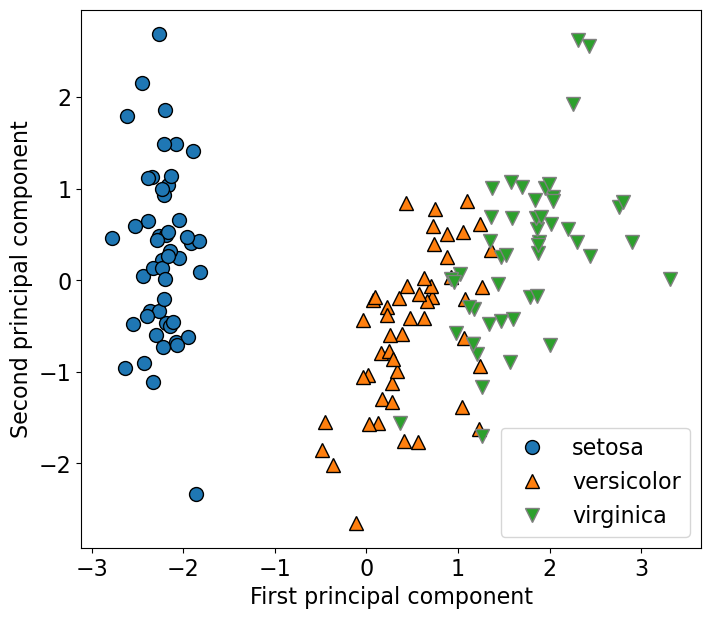

In [20]:
pca = PCA(n_components=2)
pca.fit(X_scaled)

# transform data onto the first two principal components
X_pca = pca.transform(X_scaled)

print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))
print("PCA component shape: {}".format(pca.components_.shape))

plt.figure(figsize=(8, 8))
discrete_scatter(X_pca[:, 0], X_pca[:, 1], iris.target)
plt.legend(iris.target_names, loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

## PCA Example 3: Noise Reduction <a name="pca3"></a>

Original shape: (1797, 64)
PCA component: (12, 64)
filterd shape: (1797, 64)


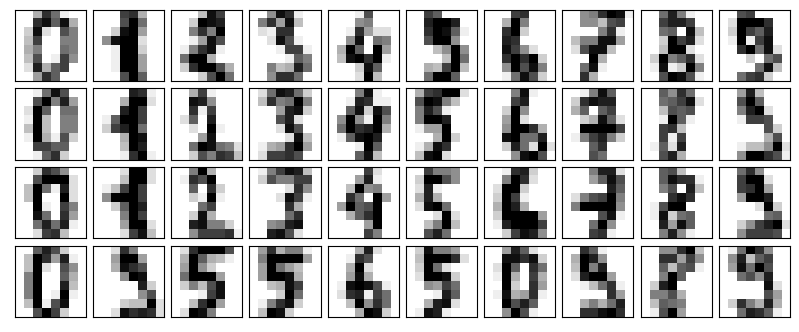

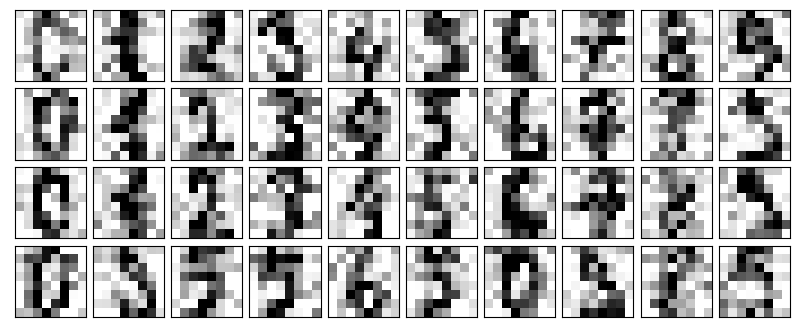

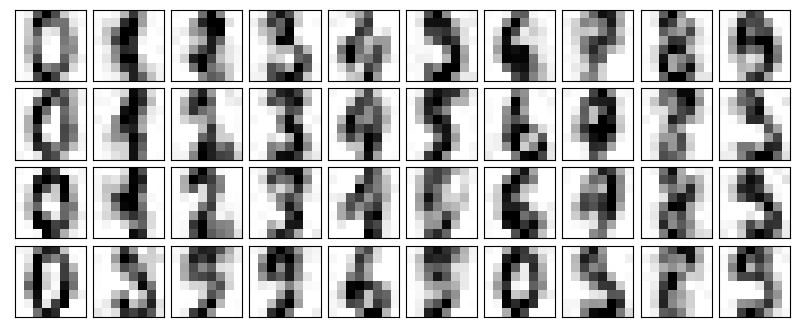

In [21]:
## PCA for Noise filtering example
from sklearn.datasets import load_digits

def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
        
#load and show digits dataset 
digits = load_digits()
digits.data.shape
plot_digits(digits.data)
print("Original shape: {}".format(str(digits.data.shape)))

#add random noise 
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

#PCA to preserve 50% varianace 
pca = PCA(0.50).fit(noisy)

#show reconstructed data 
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)
print("PCA component: {}".format(pca.components_.shape))
print("filterd shape: {}".format(str(filtered.shape)))


## Multidimensional Scaling <a name="mds"></a>

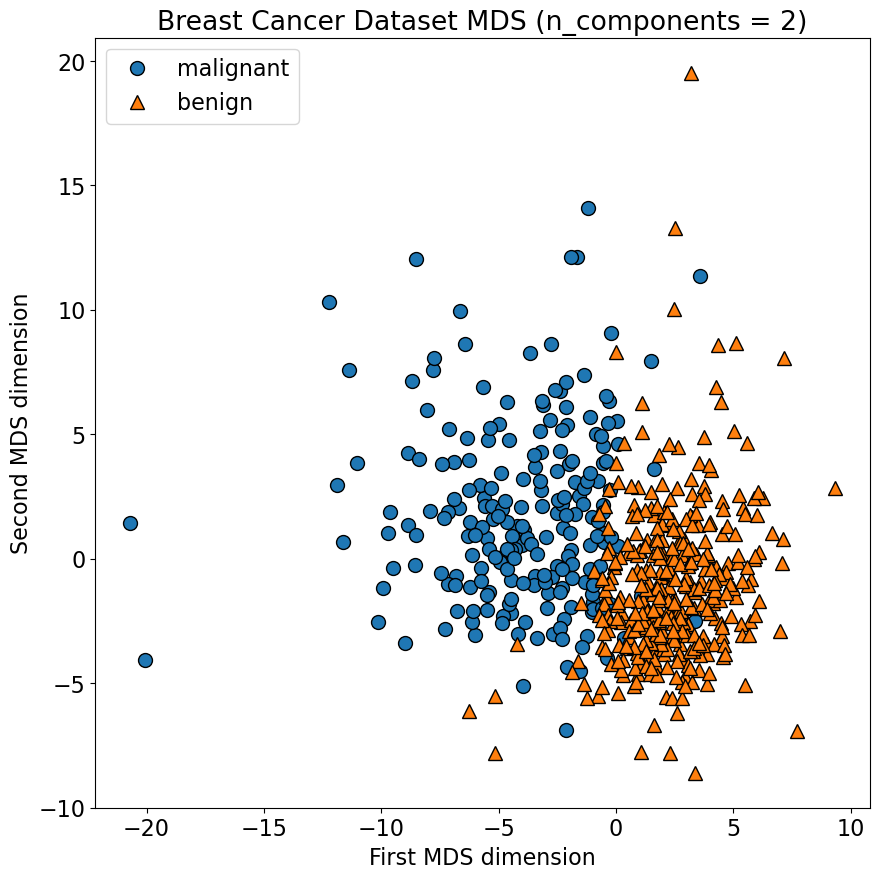

In [22]:
# Multidimensional scaling (MDS) on the breast cancer dataset
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

# each feature should be centered (zero mean) and with unit variance
X_normalized = StandardScaler().fit(X_cancer).transform(X_cancer)  

mds = MDS(n_components = 2)

X_mds = mds.fit_transform(X_normalized)

plt.figure(figsize=(10, 10))
discrete_scatter(X_mds[:, 0], X_mds[:, 1],  cancer.target)
plt.legend(["malignant", "benign"], loc="best")
plt.xlabel('First MDS dimension')
plt.ylabel('Second MDS dimension')
plt.title('Breast Cancer Dataset MDS (n_components = 2)');

## Locally Linear Embedding <a name="lle"></a>

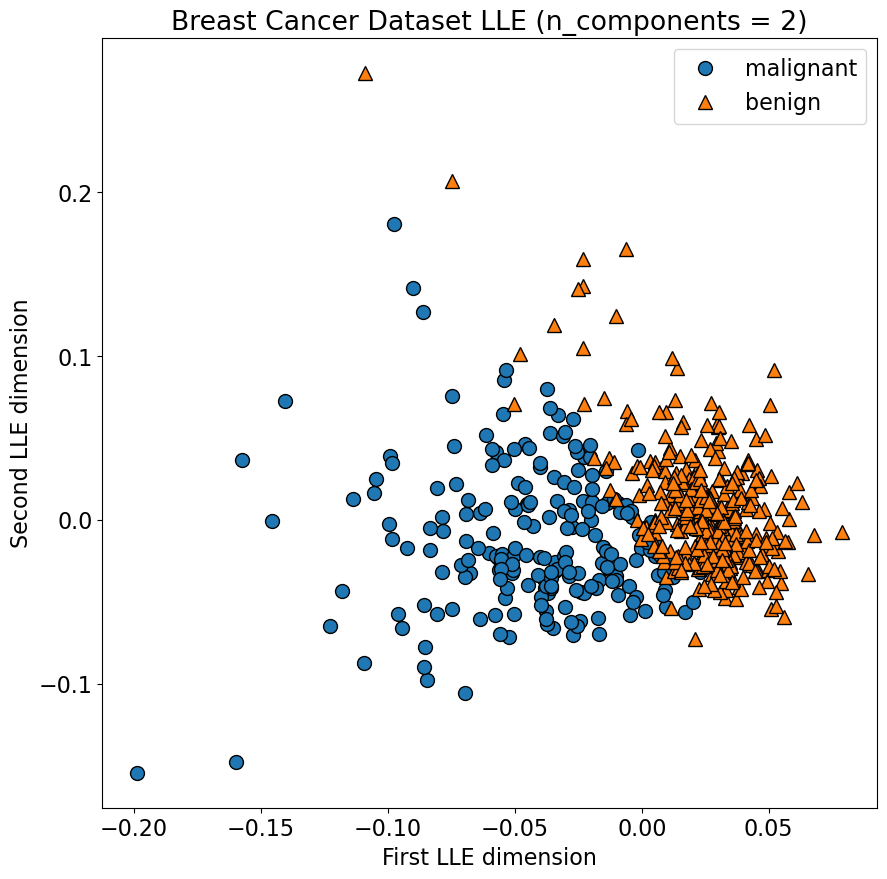

In [23]:
from sklearn.manifold import LocallyLinearEmbedding
cancer = load_breast_cancer()
(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

# each feature should be centered (zero mean) and with unit variance
X_normalized = StandardScaler().fit(X_cancer).transform(X_cancer)  

model = LocallyLinearEmbedding(n_neighbors=500, n_components=2, method='modified',
                               eigen_solver='dense')
X_lle = model.fit_transform(X_normalized)

plt.figure(figsize=(10, 10))
discrete_scatter(X_lle[:, 0], X_lle[:, 1],  cancer.target)
plt.legend(["malignant", "benign"], loc="best")
plt.xlabel('First LLE dimension')
plt.ylabel('Second LLE dimension')
plt.title('Breast Cancer Dataset LLE (n_components = 2)');


## T-SNE <a name="tsne"></a>

/Users/vkren/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/vkren/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


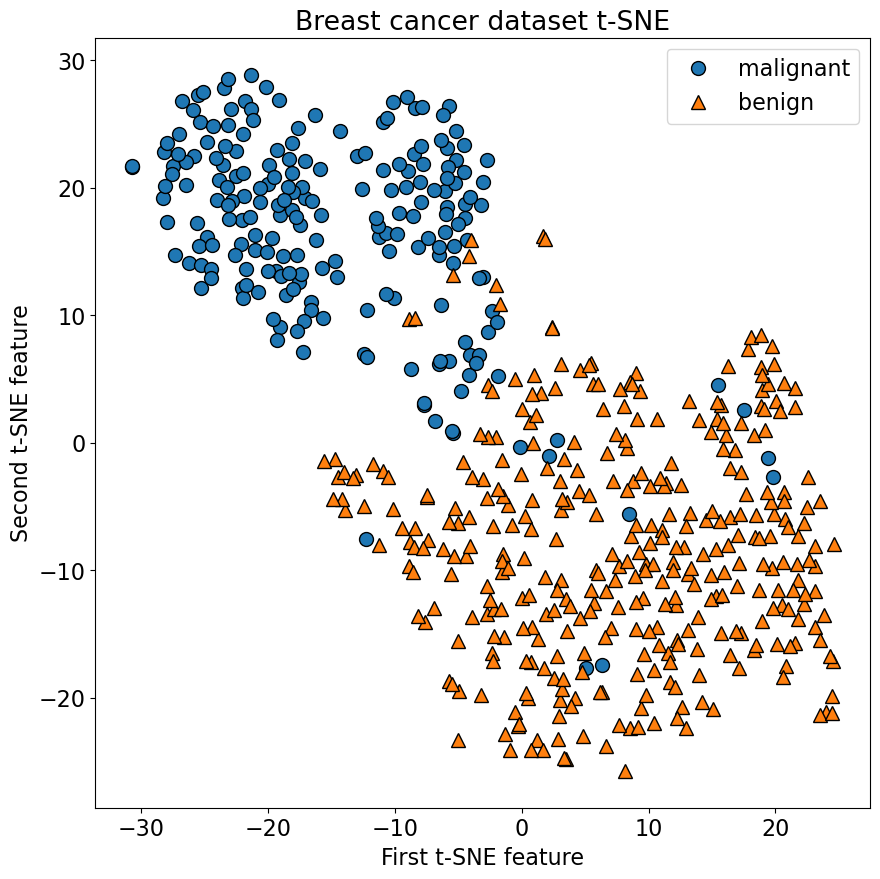

In [24]:
# t-SNE on the breast cancer dataset
from sklearn.manifold import TSNE
cancer = load_breast_cancer()
(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

# each feature should be centered (zero mean) and with unit variance
X_normalized = StandardScaler().fit(X_cancer).transform(X_cancer)  

tsne = TSNE(random_state = 0)

X_tsne = tsne.fit_transform(X_normalized)

plt.figure(figsize=(10, 10))
discrete_scatter(X_tsne[:, 0], X_tsne[:, 1],  cancer.target)
plt.legend(["malignant", "benign"], loc="best")
plt.xlabel('First t-SNE feature')
plt.ylabel('Second t-SNE feature')
plt.title('Breast cancer dataset t-SNE');